In [1]:
# | code-summary: code -- load dependencies and data and select parameters


from compmemlearn.fitting import generate_objective_function, apply_and_concatenate
from compmemlearn.datasets import events_metadata
from compmemlearn.datasets import simulate_df
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "HealKaha15_notask"

data_path = "../data/HealyKahana2014.csv"
results_path = "results/"
trial_query = "task == -1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR"]

free_parameters = [
    [
        'encoding_drift_rate',
        'start_drift_rate',
        'recall_drift_rate',
        'shared_support',
        'item_support',
        'learning_rate',
        'primacy_scale',
        'primacy_decay',
        'stop_probability_scale',
        'stop_probability_growth',
        'choice_sensitivity',
        'delay_drift_rate'
    ],
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        'choice_sensitivity',
        #    "context_sensitivity",
        #    "feature_sensitivity",
        "delay_drift_rate",
    ]
]

bounds = [
    [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
    ],
        [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"context_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

experiment_count = 100


In [2]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    cost_function = generate_objective_function(
        events,
        trial_query,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')

131563.40408603658
492128.009358859
131563.40408603658
492128.009358859


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

individual_fits = []

for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    for subject in pd.unique(events.subject):
        print(f'{model_names[model_index]}, Subject {subject}')

        subject_specific_trial_query = f'subject == {subject}'
        if trial_query:
            subject_specific_trial_query = trial_query + ' & ' + subject_specific_trial_query

        try:
            # cost function to be minimized
            # ours scales inversely with the probability that the data could have been
            # generated using the specified parameters and our model
            trials, list_lengths, presentations = events_metadata(events, subject_specific_trial_query)[:3]
            cost_function = generate_objective_function(
                events,
                subject_specific_trial_query,
                init_model,
                fixed_parameters[model_index],
                free_parameters[model_index],
            )
        except ValueError:
            continue

        fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

        fitted_parameters = {
            'subject': subject, 'trial_count': len(trials), 
            'likelihood': fit_result.fun, 'model': model_names[model_index]
            }
        for i in range(len(fit_result.x)):
            fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
        for key in fixed_parameters[model_index]:
            fitted_parameters[key] = fixed_parameters[model_index][key]

        individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
        print(individual_fits[-1]['likelihood'][0])

individual_fits = pd.concat(individual_fits, ignore_index=True)
individual_fits.to_csv(results_path + 'individual_{}.csv'.format(section_tag), index=False)
individual_fits.head()

PrototypeCMR, Subject 63
699.197475078036
PrototypeCMR, Subject 64
509.92678108824725
PrototypeCMR, Subject 65
506.9880728457299
PrototypeCMR, Subject 66
620.8528326440606
PrototypeCMR, Subject 67
632.5491264988132
PrototypeCMR, Subject 69
637.7958398731724
PrototypeCMR, Subject 70
508.3408476207135
PrototypeCMR, Subject 73
655.2191108633915
PrototypeCMR, Subject 74
595.509144713976
PrototypeCMR, Subject 75
434.2478049298883
PrototypeCMR, Subject 76
645.1001027462481
PrototypeCMR, Subject 77
642.705966679441
PrototypeCMR, Subject 79
544.3758218521712
PrototypeCMR, Subject 81
686.7810175301936
PrototypeCMR, Subject 82
631.1699870091591
PrototypeCMR, Subject 84
535.1871541697451
PrototypeCMR, Subject 85
457.38403854926094
PrototypeCMR, Subject 86
644.9962775344054
PrototypeCMR, Subject 87
511.5836245304367
PrototypeCMR, Subject 88
674.8843587703908
PrototypeCMR, Subject 89
610.7207166690374
PrototypeCMR, Subject 90
643.7239079394427
PrototypeCMR, Subject 91
548.0107813644465
PrototypeCMR

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,...,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,sampling_rule,mfc_familiarity_scale,mcf_familiarity_scale,drift_familiarity_scale,context_sensitivity,feature_sensitivity
0,63,28,699.197475,PrototypeCMR,0.871549,0.589974,0.814024,0.900619,0.124232,0.744302,...,0.003282,0.381293,9.461906,0.018384,0,0,0,0,NaN,NaN
1,64,28,509.926781,PrototypeCMR,0.677643,0.0,1.0,0.22008,0.0,0.667337,...,0.002648,0.284378,6.083765,0.704754,0,0,0,0,NaN,NaN
2,65,28,506.988073,PrototypeCMR,0.855526,0.175877,0.700537,0.302807,1.0,0.430765,...,0.00515,0.405294,5.033091,0.2238,0,0,0,0,NaN,NaN
3,66,28,620.852833,PrototypeCMR,0.765695,0.228026,0.885675,0.638452,0.0,0.425414,...,0.000723,0.47061,7.812209,0.697447,0,0,0,0,NaN,NaN
4,67,28,632.549126,PrototypeCMR,0.752638,0.0,0.916134,0.519783,0.572634,0.582823,...,0.000639,0.475624,7.486357,0.064585,0,0,0,0,NaN,NaN


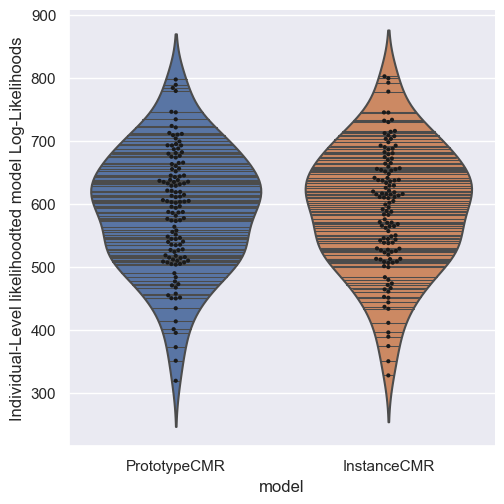

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

individual_fits = pd.read_csv('results/individual_{}.csv'.format(section_tag))
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood');
plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption))

::: {#fig-HealKaha15_notaskfits layout-nrow=2 layout-valign="center"}

![](individual_HealKaha15_notask.pdf)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |      126      |        126     |
| mean  |      591.288  |        590.054 |
| std   |       96.8336 |         95.41  |
| min   |      327.545  |        319.065 |
| 25%   |      525.486  |        519.656 |
| 50%   |      603.128  |        602.269 |
| 75%   |      656.282  |        655.78  |
| max   |      802.601  |        797.57  |

Distribution of log-likelihood scores of recall sequences exhibited by each subject in PEERS dataset under each considered model.
:::


In [9]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

individual_fits = pd.read_csv(results_path + 'individual_{}.csv'.format(section_tag))
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood))
    print()

('PrototypeCMR', 'InstanceCMR')
Ttest_relResult(statistic=-1.1674183639235716, pvalue=0.24526353394771327)



2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800
2800


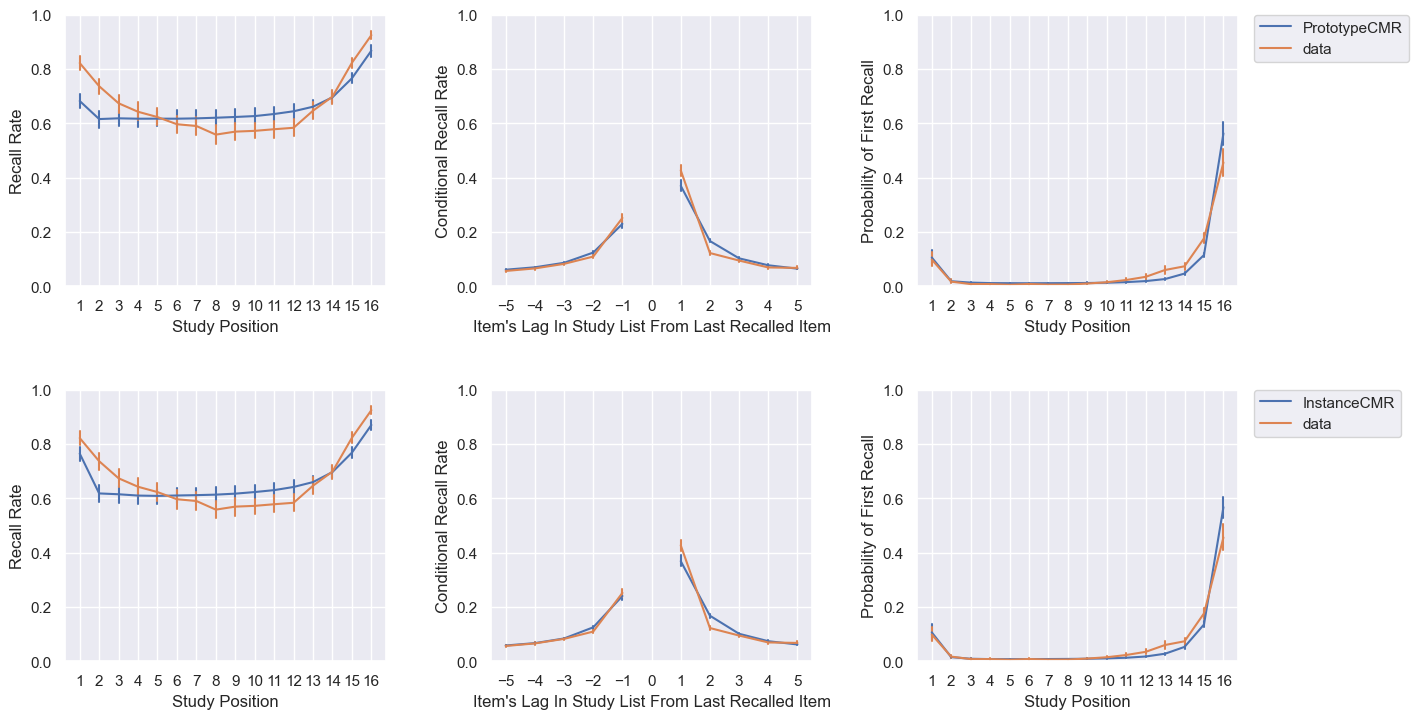

In [8]:
sns.set(style='darkgrid')

if 'list length' in events.columns:
    list_lengths = List([int(each) for each in pd.unique(events["list length"])])
else:
    list_lengths = List([int(np.max(events.input))])

# for each unique list length
for list_length in list_lengths:

    fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # for each unique matching entry in individual df
        sim_dfs = []
        for subject in pd.unique(individual_fits.subject):
            
            fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

            # configure model based on specified parameters
            fitted_parameters = Dict.empty(
                key_type=types.unicode_type, value_type=types.float64
            )
            for i in range(len(free_parameters[model_index])):
                fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            # simulate df based on specified trial_count and experiment_count
            model = model_class(list_length, list_length, fitted_parameters)
            sim_dfs.append(simulate_df(model, fit_result['trial_count'].values[0] * experiment_count))
            sim_dfs[-1].list = sim_dfs[-1].subject
            sim_dfs[-1].subject = subject

        # concatenate simulations into one dataframe
        sim_df = pd.concat(sim_dfs)
    
        # obtain parallel true_df structure
        if len(list_lengths) > 1:
            true_df = events.query(trial_query).query(f'`list length` == {list_length}')
        else:
            true_df = events.query(trial_query)

        sim_spc = apply_and_concatenate(
                fr.spc,
                sim_df,
                true_df,
                contrast_name="source",
                labels=[model_names[model_index], "data"],
            )

        sim_lag_crp = apply_and_concatenate(
                fr.lag_crp,
                sim_df,
                true_df,
                "source",
                labels=[model_names[model_index], "data"],
            )

        sim_pfr = apply_and_concatenate(
                fr.pnr,
                sim_df,
                true_df,
                contrast_name="source",
                labels=[model_names[model_index], "data"],
            )
        sim_pfr = sim_pfr.query("output <= 1")

        # serial position curve
        sns.lineplot(ax=axes[model_index, 0], data=sim_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
        axes[model_index, 0].set(xlabel='Study Position', ylabel='Recall Rate')
        axes[model_index, 0].set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
        axes[model_index, 0].set_ylim((0, 1))

        # lag crp curve
        max_lag = 5
        filt_neg = f'{-max_lag} <= lag < 0'
        filt_pos = f'0 < lag <= {max_lag}'

        sns.lineplot(ax=axes[model_index, 1], data=sim_lag_crp.query(filt_neg), x='lag', y='prob', 
                    err_style='bars', hue='source', legend=False)
        sns.lineplot(ax=axes[model_index, 1], data=sim_lag_crp.query(filt_pos), x='lag', y='prob', 
                    err_style='bars', hue='source', legend=False)
        axes[model_index, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
        axes[model_index, 1].set_xticks(np.arange(-5, 6, 1))
        axes[model_index, 1].set_ylim((0, 1))


        # pfr
        sns.lineplot(data=sim_pfr, x='input', y='prob', err_style='bars', ax=axes[model_index, 2], hue='source')
        axes[model_index, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
        axes[model_index, 2].set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
        axes[model_index, 2].set_ylim((0, 1))

        # set legend of axis 2 outside the plot, to the right
        axes[model_index, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout(pad=3)
    plt.savefig(f'{results_path}overall_{section_tag}_length_{list_length}.pdf', bbox_inches='tight')